 # What is Pneumonia?


> Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia. Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis. The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.

<img src="Assests/download.jpeg" width="700">

# Symptoms : 

- Chest pain when you breathe or cough
- Confusion or changes in mental awareness (in adults age 65 and older)
- Cough, which may produce phlegm
- Fatigue
- Fever, sweating and shaking chills
- Lower than normal body temperature (in adults older than age 65 and people with weak immune systems)
- Nausea, vomiting or diarrhea
- Shortness of breath



# Importing the necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

2023-07-05 13:09:23.320544: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu
2023-07-05 13:09:23.320572: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Dataset description

> The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))     # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset

In [3]:
train = get_data('chest_xray/chest_xray/train')
test = get_data('chest_xray/chest_xray/test')
val = get_data('chest_xray/chest_xray/val')

/opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


# Data Visualization & Preprocessing

**Let's check out the dataset we're working on by picking out two data points from the dataset.**

In [4]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

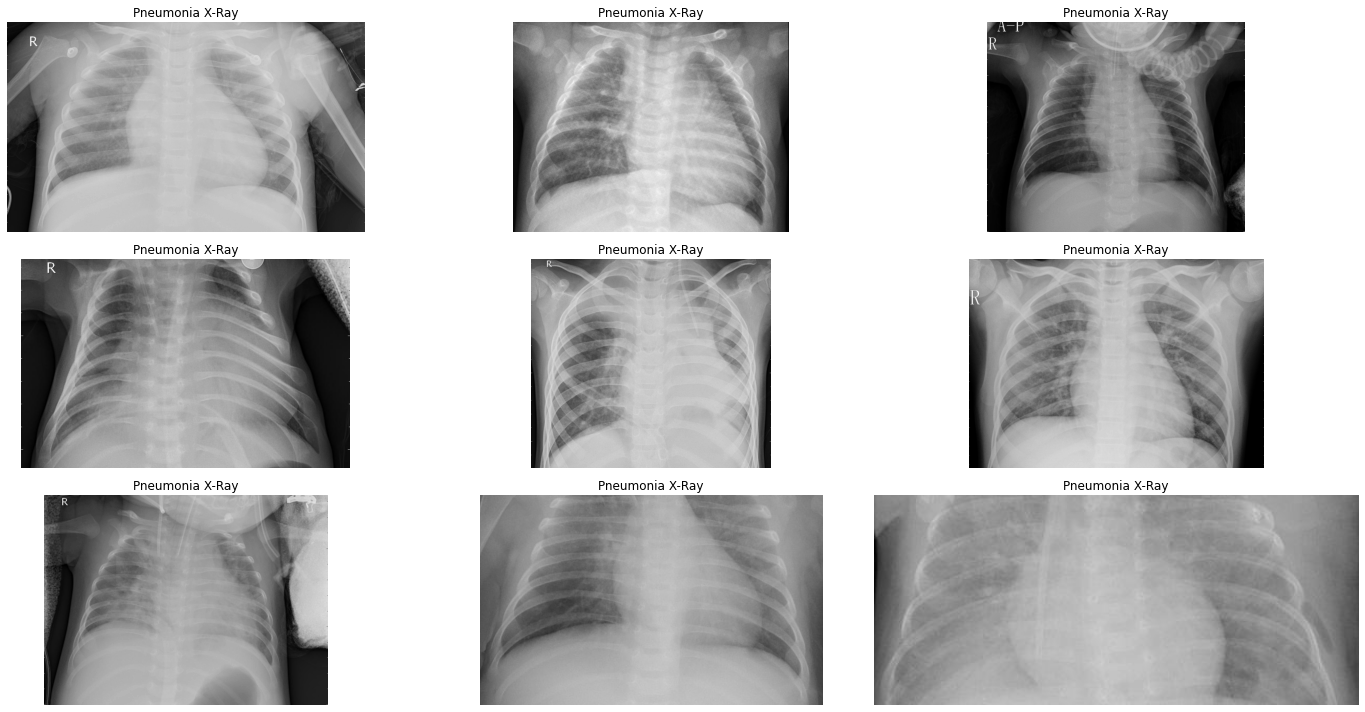

In [5]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray") 
plt.tight_layout()

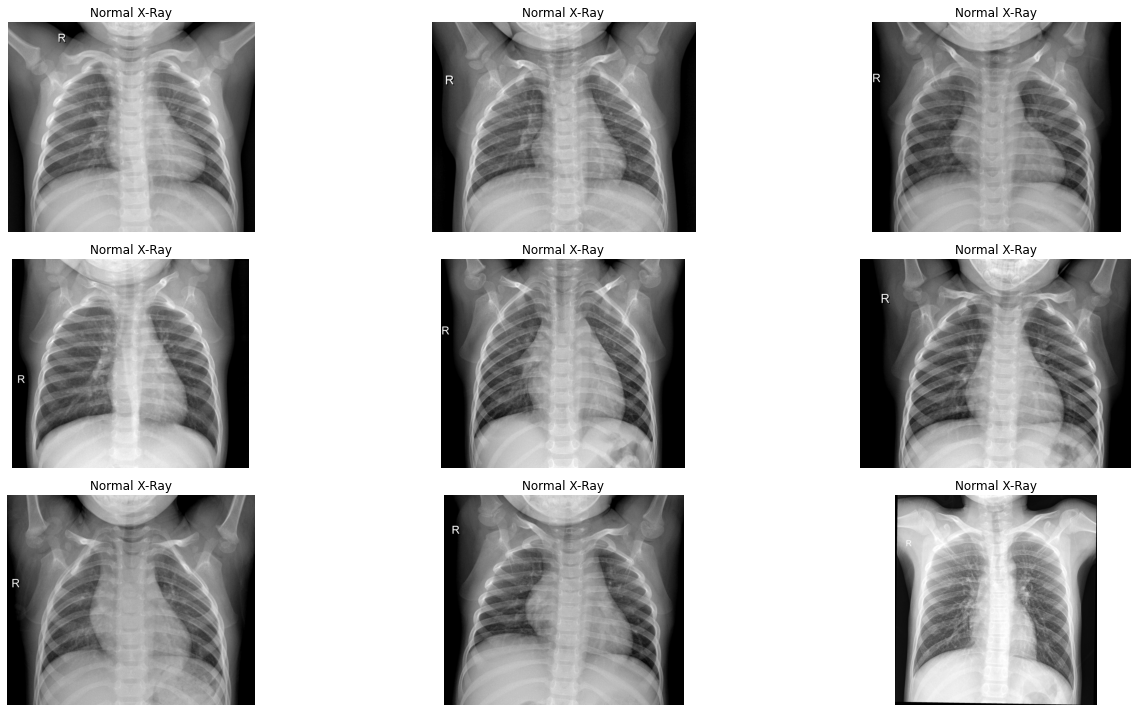

In [6]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Normal X-Ray") 
   
plt.tight_layout()

**Let's check out the number of data points we are working with in the dataset.**

In [11]:
list = []
for i in train:
    if(i[1] == 0):
        list.append("Pneumonia")
    else:
        list.append("Normal")
sns.set_style('darkgrid')
# sns.countplot(1)     

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

# Previewing the images of both the classes

Text(0.5, 1.0, 'NORMAL')

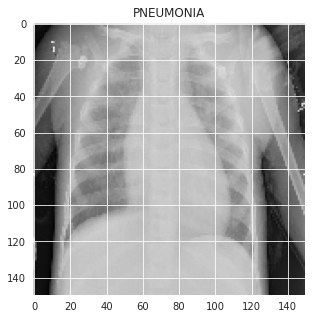

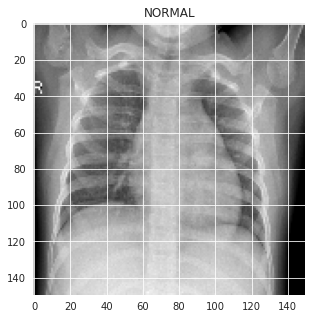

In [12]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

**Next, we perform some Data Preprocessing and Data Augmentation before we can proceed with building the model.**

In [13]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

### **Normalizing the data**

In [14]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

In [15]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

# Training the Model

**Basic Structure of CNN**

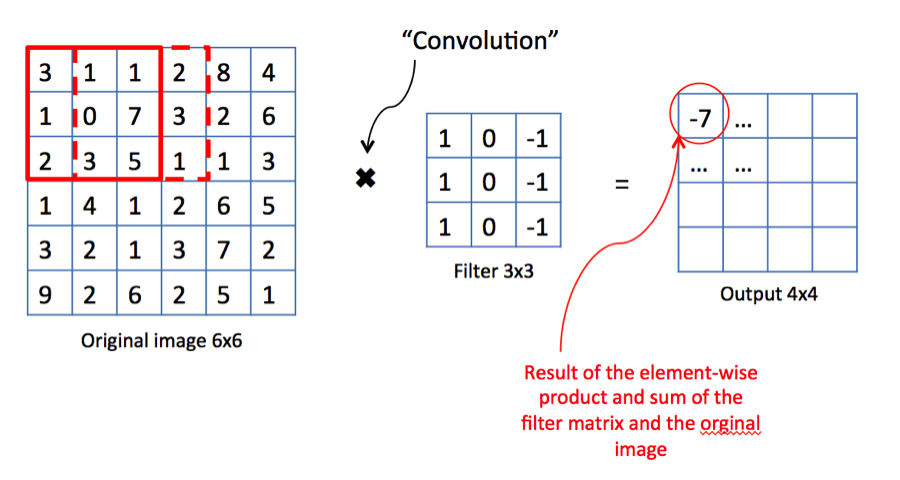

**SAME Padding: it applies padding to the input image so that the input image gets fully covered by the filter and specified stride.It is called SAME because, for stride 1 , the output will be the same as the input.**

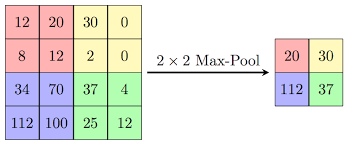


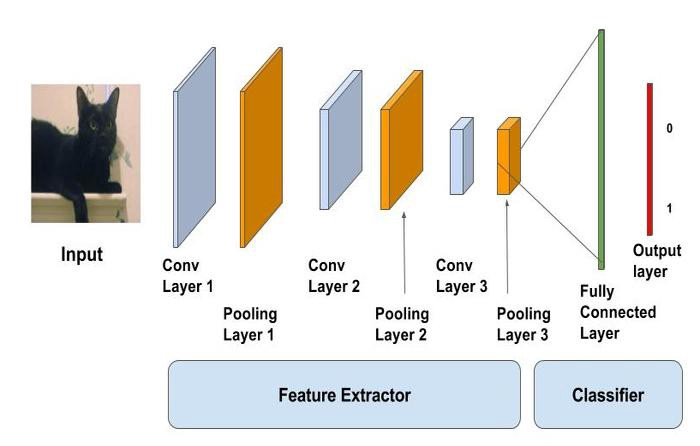
<img src="Assests/download1.png" width="700">


In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (150, 150, 1)
input_layer = Input(shape=input_shape)

# Add layers using functional API
x = Conv2D(32, (3, 3), strides=1, padding='same', activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2), strides=2, padding='same')(x)

x = Conv2D(64, (3, 3), strides=1, padding='same', activation='relu')(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2), strides=2, padding='same')(x)

x = Conv2D(64, (3, 3), strides=1, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2), strides=2, padding='same')(x)

x = Conv2D(128, (3, 3), strides=1, padding='same', activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2), strides=2, padding='same')(x)

x = Conv2D(256, (3, 3), strides=1, padding='same', activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2), strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(units=1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output)

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_10 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_8 (Dropout)         (None, 75, 75, 64)        0   

In [45]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [46]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/10
163/163 [==============================] - 72s 432ms/step - loss: 0.4894 - accuracy: 0.8265 - val_loss: 27.0028 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 68s 416ms/step - loss: 0.2762 - accuracy: 0.8969 - val_loss: 41.6299 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.2355 - accuracy: 0.9191
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 56s 344ms/step - loss: 0.2355 - accuracy: 0.9191 - val_loss: 36.2196 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 76s 469ms/step - loss: 0.1551 - accuracy: 0.9433 - val_loss: 31.9239 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - 104s 637ms/step - loss: 0.1402 - accuracy: 0.9546 - val_loss: 0.7143 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 6/10
163/163 [================

In [47]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 81ms/step - loss: 0.3500 - accuracy: 0.8942
Loss of the model is -  0.35003140568733215
20/20 [==============================] - 2s 78ms/step - loss: 0.3500 - accuracy: 0.8942
Accuracy of the model is -  89.42307829856873 %


# Analysis after Model Training

In [48]:

from tensorflow_model_optimization.quantization.keras import vitis_quantize

In [49]:
quantizer = vitis_quantize.VitisQuantizer(model)
quantized_model = quantizer.quantize_model(calib_dataset = x_test, weight_bit=8, activation_bit=8)

quantized_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

score = quantized_model.evaluate(x_test,y_test ,verbose=0, batch_size=1)
print(score)
print('last')
quantized_model.save('pneumonia.h5')

[VAI INFO] Update activation_bit: 8
[VAI INFO] Update weight_bit: 8
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 3s 281ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Quantize Calibration...
20/20 [==============================] - 25s 885ms/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quant Model Refinement...
[VAI INFO] Start Quantize Position Ajustment...
[VAI INFO] Quantize Position Ajustment Done.
[VAI INFO] Post-Quant Model Refninement Done.
[VAI INFO] Start Model Finalization...
[VAI INFO] Model Finalization Done.
[VAI INFO] Quantization Finished.
[nan, 0.9086538553237915]
last


ValueError: x and y must have same first dimension, but have shapes (12,) and (1,)

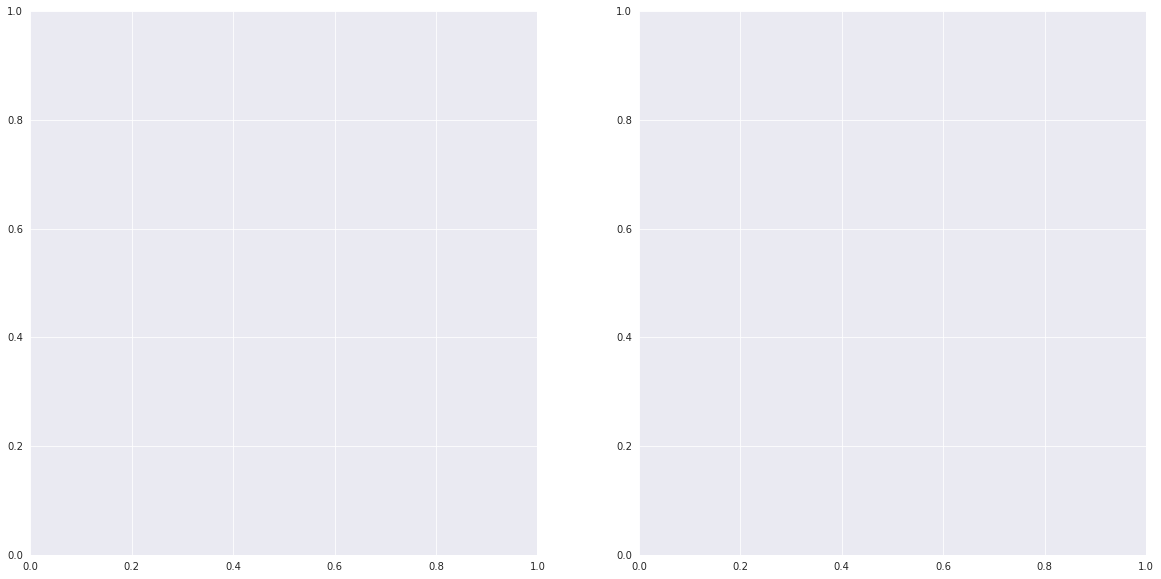

In [40]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

# Predictions

In [31]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [32]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

NameError: name 'predictions' is not defined

In [22]:
cm = confusion_matrix(y_test,predictions)
cm

NameError: name 'predictions' is not defined

In [23]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

NameError: name 'cm' is not defined

In [24]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

NameError: name 'cm' is not defined

<Figure size 720x720 with 0 Axes>

In [25]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

NameError: name 'predictions' is not defined

**Some of the Correctly Predicted Classes**

In [26]:
i = 0
for c in correct[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

NameError: name 'correct' is not defined

**Some of the Incorrectly Predicted Classes**

In [27]:
i = 0
for c in incorrect[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

NameError: name 'incorrect' is not defined

In [28]:
#model.save(../model.h5)

In [41]:

from tensorflow_model_optimization.quantization.keras import vitis_quantize

In [43]:
quantizer = vitis_quantize.VitisQuantizer(model)
quantized_model = quantizer.quantize_model(calib_dataset = x_test, weight_bit=8, activation_bit=8)

quantized_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

score = quantized_model.evaluate(x_test,y_test ,verbose=0, batch_size=1)
print(score)
print('last')
quantized_model.save('pneumonia.h5')

[VAI INFO] Update activation_bit: 8
[VAI INFO] Update weight_bit: 8
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 2s 184ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Quantize Calibration...
20/20 [==============================] - 19s 726ms/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quant Model Refinement...
[VAI INFO] Start Quantize Position Ajustment...
[VAI INFO] Quantize Position Ajustment Done.
[VAI INFO] Post-Quant Model Refninement Done.
[VAI INFO] Start Model Finalization...
[VAI INFO] Model Finalization Done.
[VAI INFO] Quantization Finished.
[nan, 0.625]
last
